In [9]:


# Common
import os 
import keras
import numpy as np
import pandas as pd
import tensorflow as tf

# Data 
from glob import glob
from tqdm import tqdm
import tensorflow.image as tfi
from tensorflow.keras.utils import load_img, img_to_array

# Data Visualization
import matplotlib.pyplot as plt

# Model
from tensorflow.keras.layers import add
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import multiply
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.models import Model

# Model Visualization
from tensorflow.keras.utils import plot_model



In [10]:
# Root Path
image_paths = 'Football/images/'

# All Images and thier respective maps
all_images = glob(image_paths + "*.jpg")
all_paths = [path.replace(".jpg",".jpg___fuse.png") for path in all_images]
all_images[0]

'Football/images/Frame 1  (71).jpg'

In [11]:
def load_image(path, SIZE=256):
    image = load_img(path)
    image = tfi.resize(image, (SIZE, SIZE))
    image = img_to_array(image)
    image = tf.cast(image, tf.float32)
    image = image/255.
    return image

def load_data(image_paths, label_paths, SIZE=256):
    images, label_maps = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3)), np.zeros(shape=(len(label_paths), SIZE, SIZE, 3))
    for i, (image_path, label_path) in tqdm(enumerate(zip(image_paths, label_paths)), desc="Loading"):
        image, label_map = load_image(image_path, SIZE=SIZE), load_image(label_path, SIZE=SIZE)
        images[i], label_maps[i] = image, label_map
    return images, label_maps


In [12]:
images, label_maps = load_data(all_images, all_paths)

Loading: 100it [00:06, 14.33it/s]


In [13]:
def show_map(image, label_map, alpha_1=1, alpha_2=0.7):
    plt.imshow(image, alpha=alpha_1)
    plt.imshow(label_map, alpha=alpha_2)
    plt.axis('off')

In [14]:

def show_maps(images, label_maps, GRID=[5,6], SIZE=(25,25)):
    
    # Plot Configuration
    n_rows, n_cols = GRID
    n_images = n_rows * n_cols
    plt.figure(figsize=SIZE)
    
    # Iterate through the Data
    i=1
    for image, label_map in zip(images, label_maps):        
        # Plot Image
        plt.subplot(n_rows, n_cols, i)
        show_map(image, label_map)
        
        i+=1
        if i>n_images:
            break
    
    # Final Plot
    plt.show()


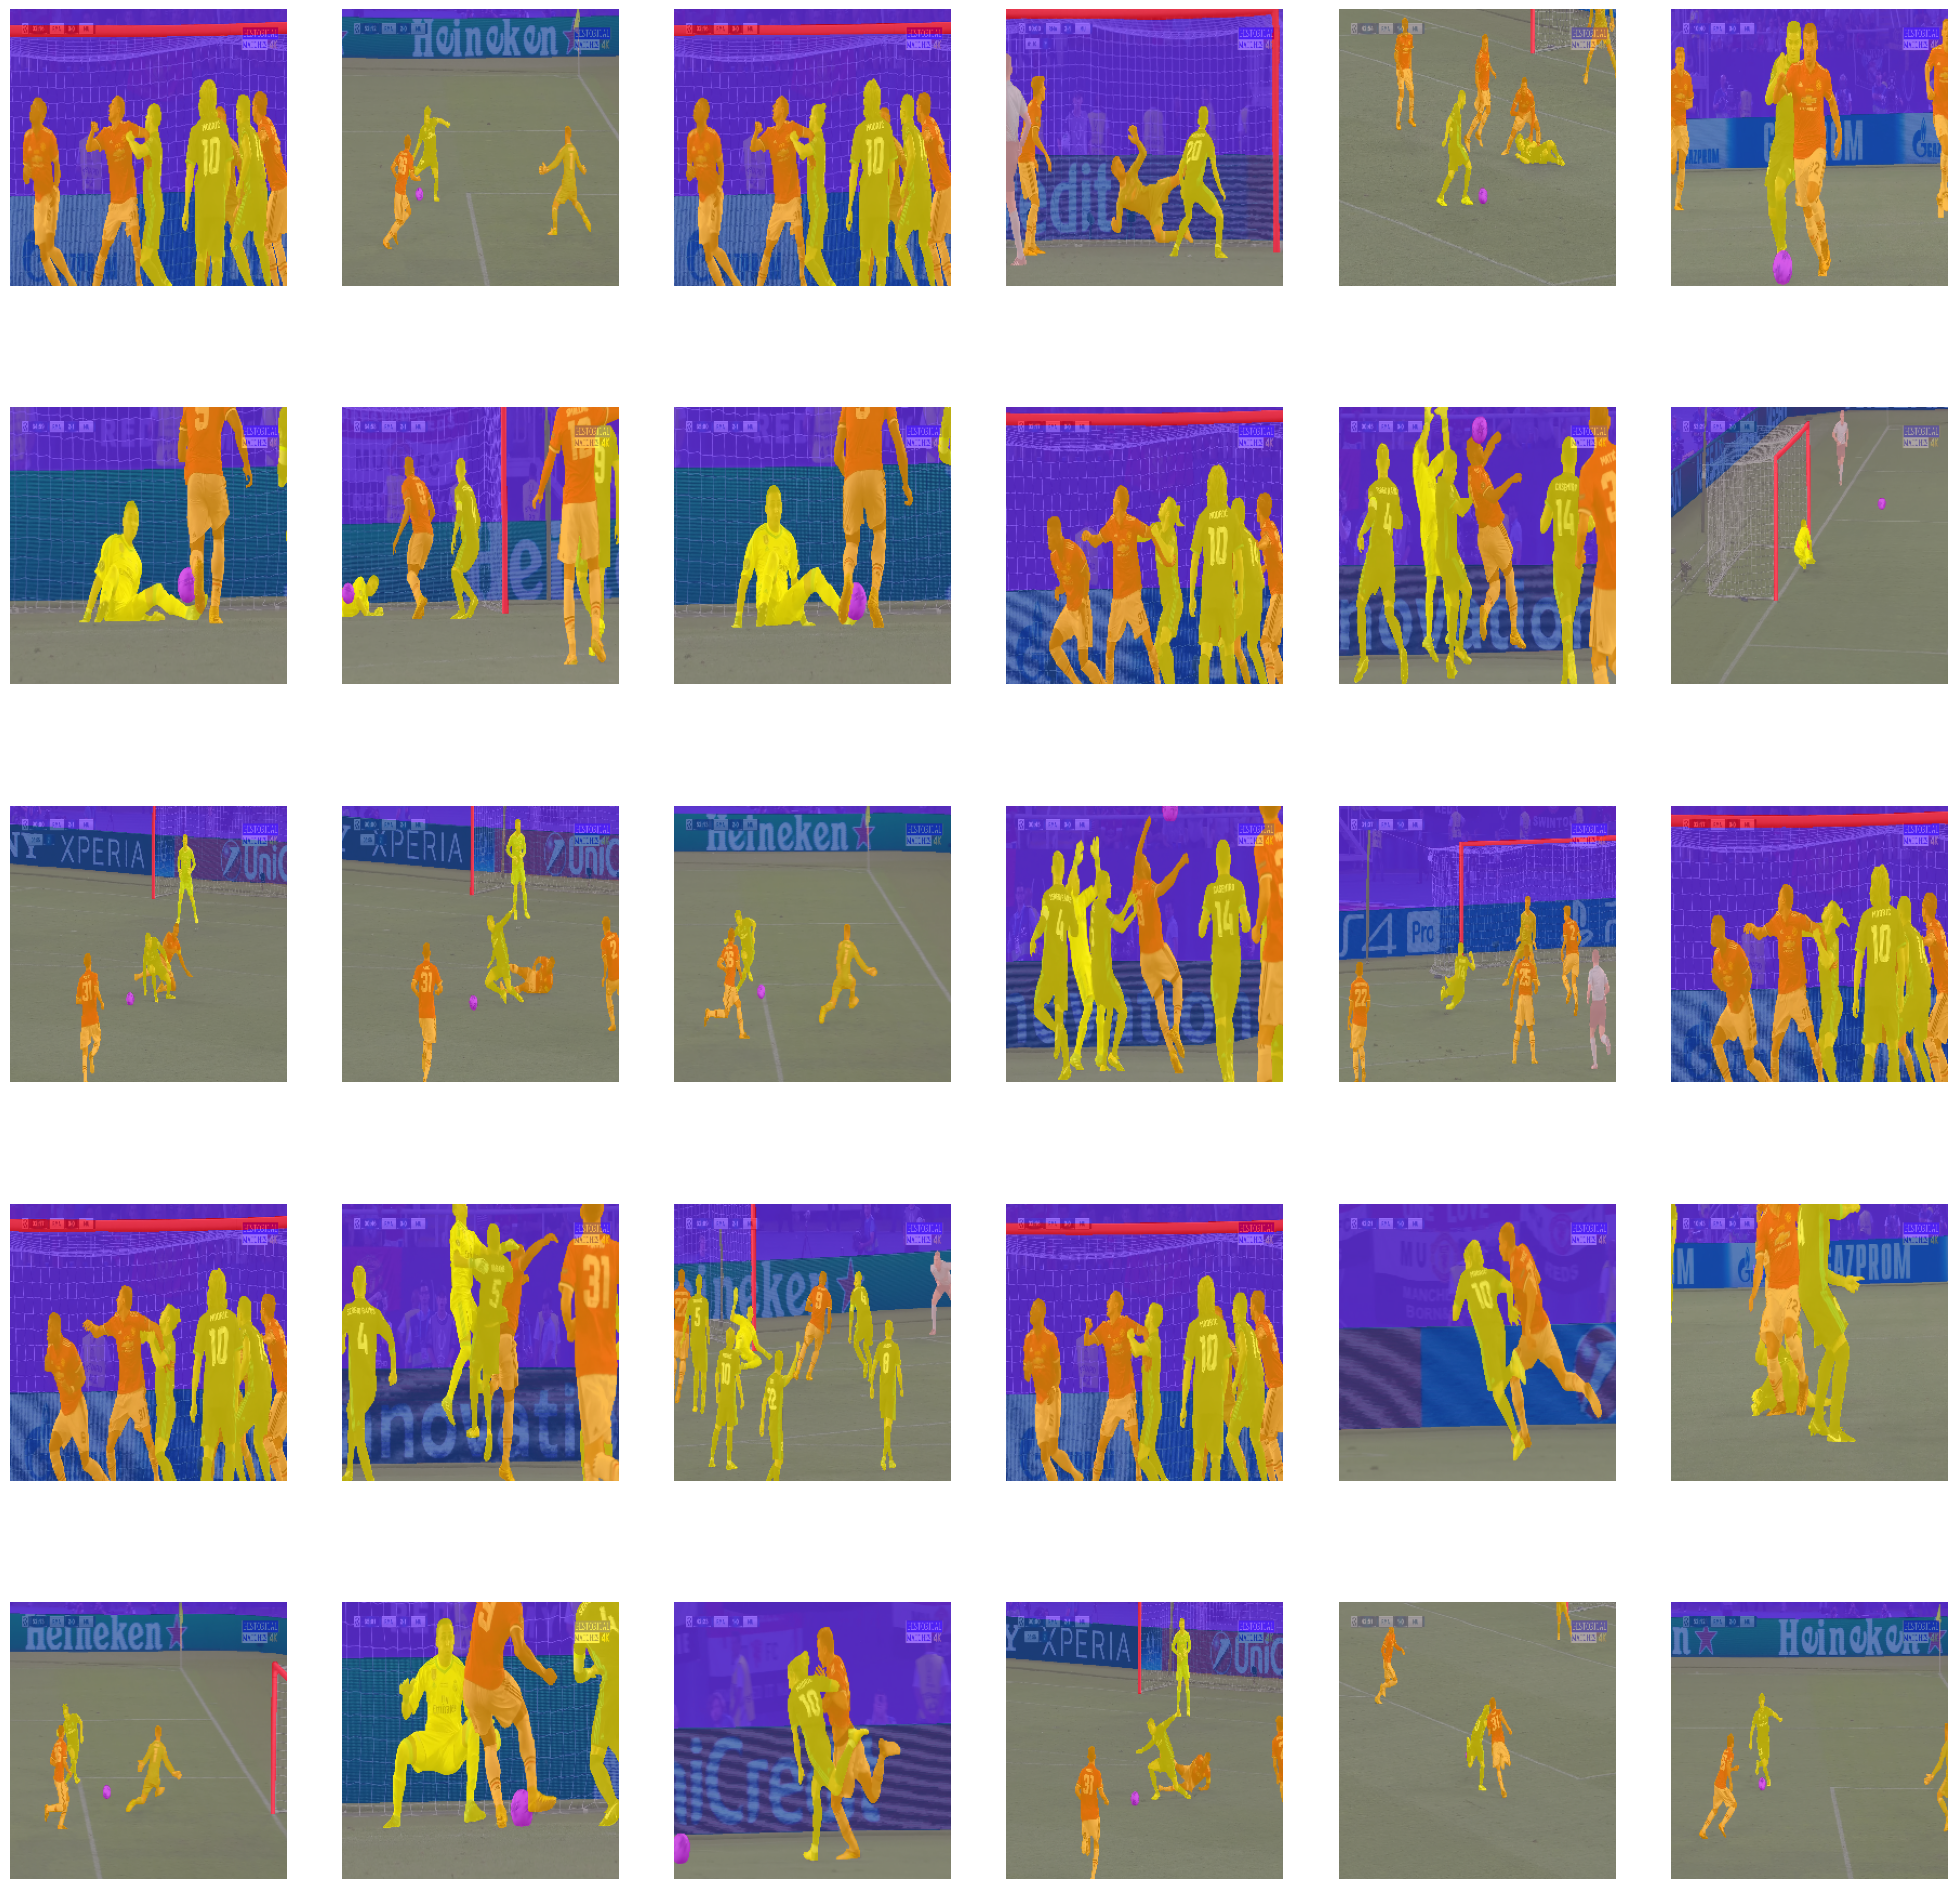

In [7]:
show_maps(images, label_maps)

In [15]:
class Encoder(Layer):
    
    def __init__(self, filters, rate=0.2, pooling=True, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        
        self.filters = filters
        self.rate = rate
        self.pooling = pooling
        
        self.bn = BatchNormalization()
        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()
    
    def call(self, X):
        x = self.c2(self.drop(self.c1(self.bn(X))))
        if self.pooling:
            y = self.pool(x)
            return x, y
        return x
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "filters":self.filters, "rate":self.rate,"pooling":self.pooling}

In [16]:


class Decoder(Layer):
    
    def __init__(self, filters, rate, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        
        self.filters = filters
        self.rate = rate
        
        self.cT = Conv2DTranspose(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.bn = BatchNormalization()
        self.skip = Concatenate()
        self.net = Encoder(filters, rate, pooling=False)
    
    def call(self, X):
        x, skip_x = X
        y = self.cT(self.bn(x))
        y = self.net(self.skip([y, skip_x]))
        return y
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "filters":self.filters, "rate":self.rate}



In [17]:
# Input Layer
InputL = Input(shape=(256,256,3), name="InputImage")

# Encoder Block 
c1, p1 = Encoder(filters=64,  rate=0.1, name="Encoder1")(InputL)
c2, p2 = Encoder(filters=128, rate=0.1, name="Encoder2")(p1)
c3, p3 = Encoder(filters=256, rate=0.2, name="Encoder3")(p2)
c4, p4 = Encoder(filters=512, rate=0.2, name="Encoder4")(p3)

# Encoding Layer
encodings = Encoder(filters=512, rate=0.3, pooling=False, name="Encoding")(p4)

# Decoder Block
d = Decoder(512, 0.2, name='Decoder1')([encodings, c4])
d = Decoder(256, 0.2, name='Decoder2')([d, c3])
d = Decoder(128, 0.1, name='Decoder3')([d, c2])
d = Decoder(64, 0.1, name='Decoder4')([d, c1])

# Output
conv_out = Conv2D(3, kernel_size=3, padding='same', activation='sigmoid', name="Segmentator")(d)

In [18]:
# Model
model = Model(InputL, conv_out, name="UNet")
model.summary()

# Compile Model
model.compile(loss='binary_crossentropy', optimizer='adam')

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputImage (InputLayer)        [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Encoder1 (Encoder)             ((None, 256, 256, 6  38732       ['InputImage[0][0]']             
                                4),                                                               
                                 (None, 128, 128, 6                                               
                                4))                                                               
                                                                                               

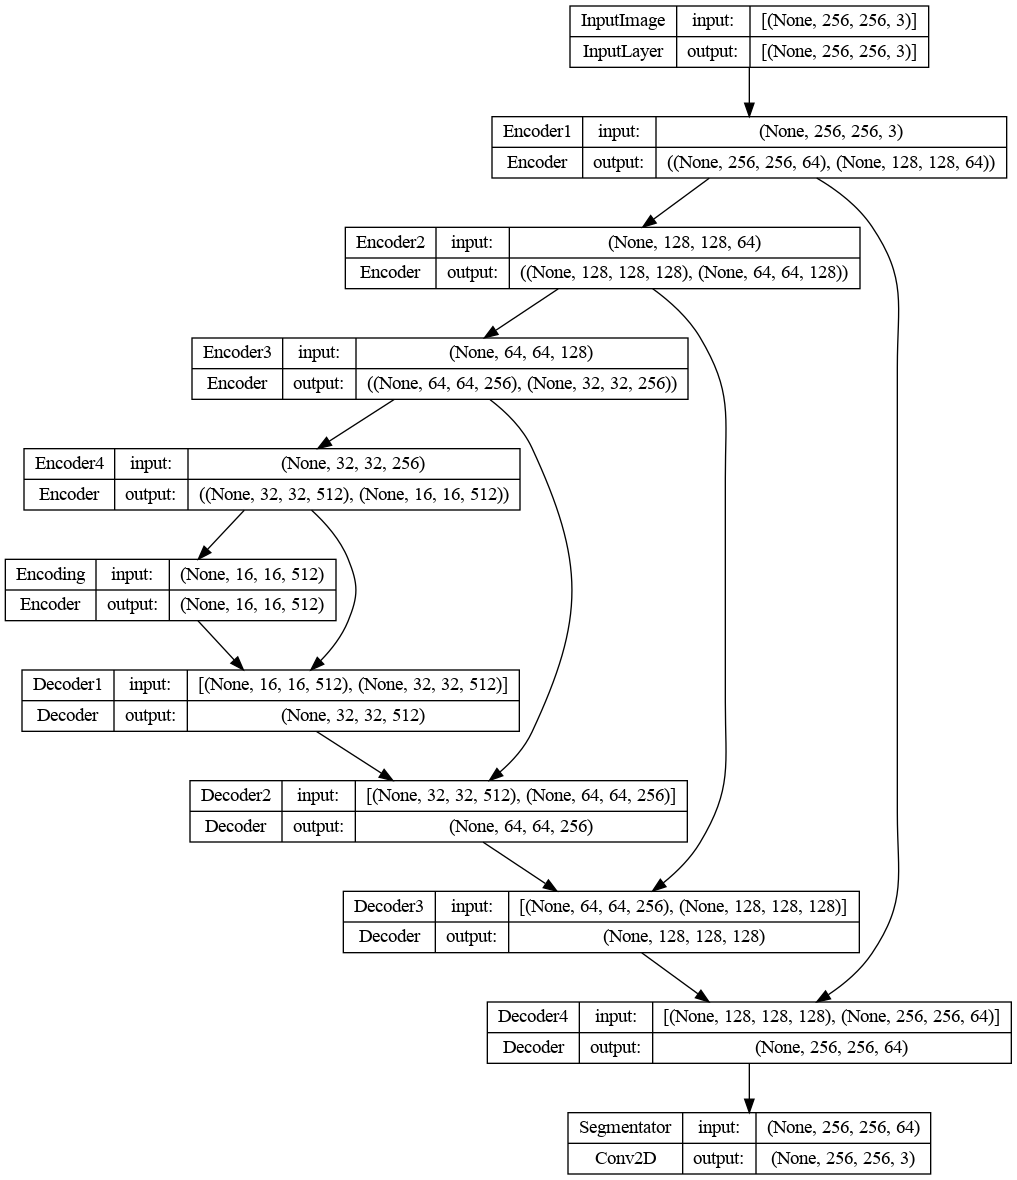

In [19]:
plot_model(model, "UNet.png", show_shapes=True)

In [20]:
BATCH_SIZE = 16
SPE = len(images)//BATCH_SIZE

def show_image(image, title=None):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

In [40]:
import numpy as np
from PIL import Image
import cv2

class ShowProgress(Callback):
    def on_epoch_end(self, epoch, logs=None):
        id = np.random.randint(len(images))
        image = images[id]
        mask = label_maps[id]
        pred_mask = self.model(tf.expand_dims(image,axis=0))[0]
        
        plt.figure(figsize=(12,10))
        plt.subplot(1,3,1)
        show_image(image, title="Original Image")
        
        plt.subplot(1,3,2)
        show_image(mask, title="Original Mask")
        
        plt.subplot(1,3,3)
        show_image(pred_mask, title="Predicted Mask")               
        plt.tight_layout()
        plt.show()

In [41]:
cbs = [ModelCheckpoint("UNetFootPlaySegment.h5", save_best_only=True),ShowProgress()]

6/6 [==============================] - ETA: 0s - loss: 0.5811  

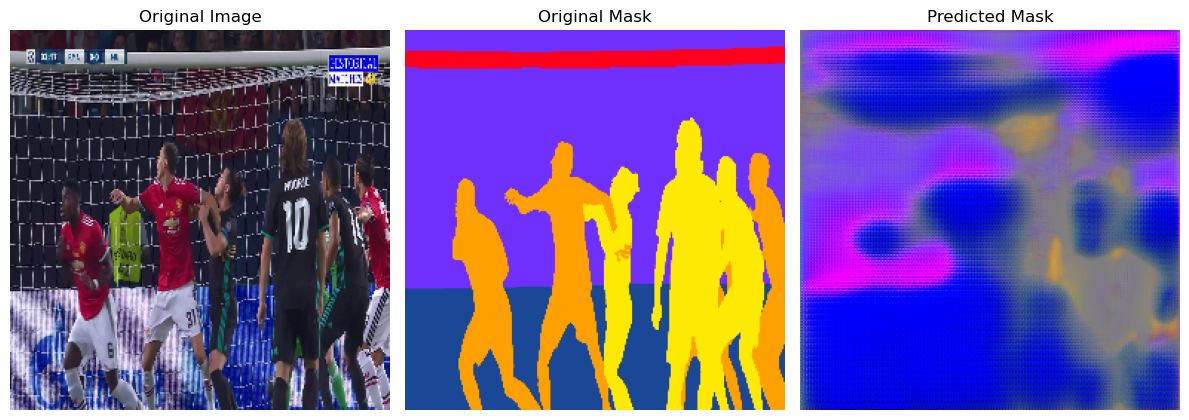

6/6 [==============================] - 566s 93s/step - loss: 0.5811 - val_loss: 1.3005


In [42]:
nepochs=1
model.fit( images, label_maps,validation_split=0.1,epochs=nepochs, batch_size=BATCH_SIZE,steps_per_epoch=SPE, callbacks=cbs)